# Introduction

Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import datetime as dt
import math
from tqdm.auto import tqdm
import glob

from scipy.stats.mstats import gmean
from scipy.stats import hmean
from scipy.stats import spearmanr

np.random.seed(0)
warnings.simplefilter("ignore")

VAR_TH = 1.0e-03
PSEUDO_NFOLDS = 5
PSEUDO_TH = 0.94
CLIP = True
VAR_SMOOTHING = 1818

In [2]:
data = pd.read_feather('../input/tps2022novfeather/train.ftr')
sub = pd.read_csv('../input/tabular-playground-series-nov-2022/sample_submission.csv')
y = pd.read_csv("../input/tabular-playground-series-nov-2022/train_labels.csv")

train = data.loc[:19999, :]
test = data.loc[20000:, :]

display(train.head())
display(sub.head())

,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,...,sub_4990,sub_4991,sub_4992,sub_4993,sub_4994,sub_4995,sub_4996,sub_4997,sub_4998,sub_4999
0,0.709336,0.799007,0.851891,0.537158,0.623930,0.705970,0.503437,0.633185,0.641550,0.666604,...,0.769207,0.750250,0.663370,0.739333,0.822384,0.749498,0.729800,0.867847,0.745888,0.787
1,0.452988,0.364453,0.567582,0.354468,0.513818,0.584119,0.454809,0.238501,0.472171,0.522314,...,0.640052,0.794052,0.721298,0.804369,0.620626,0.733606,0.816942,0.814229,0.598331,0.547
2,0.675462,0.842260,0.800013,0.525229,0.692071,0.715418,0.651008,0.609124,0.691198,0.609994,...,0.812841,0.779859,0.865657,0.828493,0.763010,0.802883,0.806891,0.896058,0.855776,0.667
3,0.481046,0.577118,0.683032,0.541356,0.630088,0.664514,0.413373,0.508210,0.526140,0.584565,...,0.824703,0.799698,0.800130,0.716604,0.603779,0.708499,0.844837,0.853057,0.850657,0.622
4,0.957339,0.910337,0.917322,0.874487,0.787595,0.854273,0.843846,0.876749,0.821128,0.913054,...,0.934803,0.900150,0.960911,0.906037,0.961240,0.935608,0.889757,0.978505,0.953681,0.934


,id,pred
0,20000,0.640707
1,20001,0.636904
2,20002,0.392496
3,20003,0.588658
4,20004,0.783603


In [3]:
print("train shape:", train.shape)
print("test shape:", test.shape)
print("sub shape:", sub.shape)

train shape: (20000, 5000)
test shape: (20000, 5000)
sub shape: (20000, 2)


In [4]:
print("train nan value sum:", train.isna().sum().sum())
print("test nan value sum:", test.isna().sum().sum())

train nan value sum: 0
test nan value sum: 0


In [5]:
print("train dublicated value sum:", train.duplicated().sum().sum())
print("test dublicated value sum:", test.duplicated().sum().sum())

train dublicated value sum: 0
test dublicated value sum: 0


# Preprocesses

In [6]:
normalized_train = (train - train.mean()) / train.std()
normalized_train.var().sort_values()

sub_1825    4.930627e-32
sub_2356    1.000000e+00
sub_4963    1.000000e+00
sub_1691    1.000000e+00
sub_1685    1.000000e+00
                ...     
sub_3226    1.000000e+00
sub_2618    1.000000e+00
sub_684     1.000000e+00
sub_1148    1.000000e+00
sub_1824             NaN
Length: 5000, dtype: float64

In [7]:
for feature in ["sub_1824", "sub_1825"]:
    print(f"train {feature} unique : {train[feature].unique()}")
    print(f"test {feature} unique : {test[feature].unique()}")

train sub_1824 unique : [0.491104]
test sub_1824 unique : [0.491104]
train sub_1825 unique : [0.51]
test sub_1825 unique : [0.51]


* sub_1824 and sub_1825 are bad predictions.

In [8]:
train.max().max(), train.min().min()

(1.356611, -0.336521)

In [9]:
if CLIP:
    train = train.clip(0,1)
    test = test.clip(0,1)
    print(train.max().max(), train.min().min())

1.0 0.0


# Feature Selection

In [10]:
sub_file_names = sorted(glob.glob('../input/tabular-playground-series-nov-2022/submission_files/*.csv'))
scores_all = [float(file_name.split('/')[-1][:-4]) for file_name in sub_file_names]
print("sub_file_names len:", len(sub_file_names))

# ref: https://www.kaggle.com/code/takanashihumbert/drop-4000-features-lb-0-51530
best = 'sub_0'
else_cols = [f for f in data.columns if f != best]
drop_cols = []
for col, score in tqdm(zip(else_cols, scores_all)):
    logloss = score
    r, _ = spearmanr(data[best].values, data[col].values)
    if r > 0.98 or logloss > 0.680:
        drop_cols.append(col)

del data
gc.collect()

sub_file_names len: 5000


0it [00:00, ?it/s]

23

In [11]:
train.drop(drop_cols, axis=1, inplace=True)
print("train.shape:", train.shape)

train.shape: (20000, 630)


# UMAP-PCA Visualization

In [12]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss
import umap

embedding = umap.UMAP(n_neighbors=50,
                      min_dist=0.5,
                      metric='manhattan').fit_transform(train)

Manhattan score: 0.5407147546761382


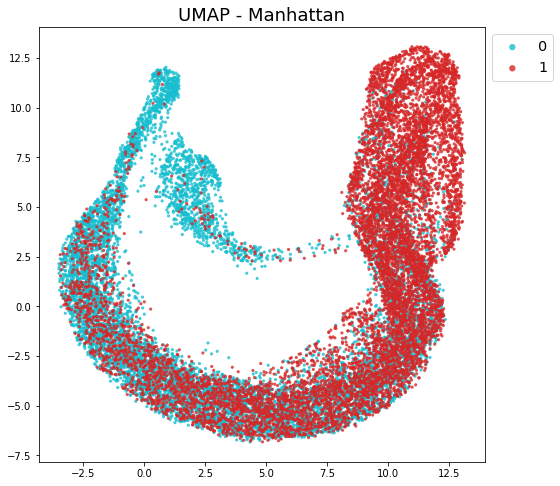

In [13]:
preds = cross_val_predict(LGBMClassifier(), embedding, y["label"], cv=5, method="predict_proba")
print("Manhattan score:", log_loss(y["label"], preds))
colors_dict = {
        0: 'tab:cyan',
        1: 'tab:red',
}
fig, ax = plt.subplots(figsize=(8,8))
for color_key in colors_dict.keys():
    indexs = y["label"] == color_key
    temp_embedding = embedding[indexs, :]
    ax.scatter(temp_embedding[:, 0], temp_embedding[:, 1], 
                c=colors_dict[color_key], 
                edgecolor='none', 
                alpha=0.80,
                label=color_key,
                s=10)
ax.legend(bbox_to_anchor=(1, 1), fontsize="x-large", markerscale=2.)
ax.set_title('UMAP - Manhattan', fontsize=18);

In [14]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca = PCA().fit(train)
print(pca.explained_variance_ratio_.cumsum()[:10])

[0.89218954 0.92142222 0.93283852 0.93762131 0.94151562 0.94479409
 0.94719723 0.94956768 0.9516112  0.95322088]


PCA score: 0.5405627782260972


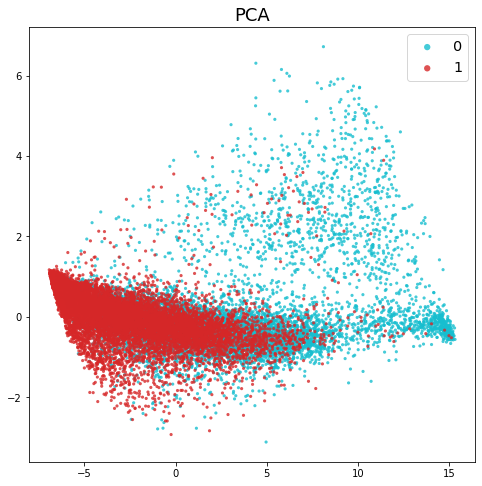

In [15]:
pca_features = PCA(n_components=2).fit_transform(train)
preds = cross_val_predict(LGBMClassifier(), pca_features, y["label"], cv=5, method="predict_proba")
print("PCA score:", log_loss(y["label"], preds))
colors_dict = {
        0: 'tab:cyan',
        1: 'tab:red',
}
fig, ax = plt.subplots(figsize=(8,8))
for color_key in colors_dict.keys():
    indexs = y["label"] == color_key
    temp_features = pca_features[indexs, :]
    ax.scatter(temp_features[:, 0], temp_features[:, 1], 
                c=colors_dict[color_key], 
                edgecolor='none', 
                alpha=0.80,
                label=color_key,
                s=10)
ax.legend(bbox_to_anchor=(1, 1), fontsize="x-large", markerscale=2.)
ax.set_title('PCA', fontsize=18);

c=2 PCA score: 0.5426488295106264
c=3 PCA score: 0.5419724689800003
c=4 PCA score: 0.5383455499313595
c=5 PCA score: 0.5384456227421452
c=6 PCA score: 0.5378330511092512
c=7 PCA score: 0.537262235557815
c=8 PCA score: 0.5370505828566938
c=9 PCA score: 0.5368429103074702
c=10 PCA score: 0.5368453767724622


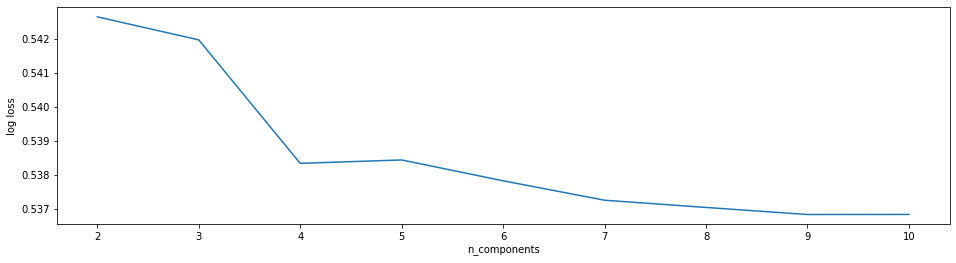

In [16]:
n_components_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
score_list = []
for c in n_components_list:
    pca_features = PCA(n_components=c, random_state=42).fit_transform(train)
    preds = cross_val_predict(LogisticRegression(random_state=42), pca_features, y["label"], cv=5, method="predict_proba")
    pca_score = log_loss(y["label"], preds)
    print(f"c={c} PCA score:", pca_score)
    score_list.append(pca_score)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(n_components_list, score_list)
ax.set_ylabel("log loss")
ax.set_xlabel("n_components");

# Adding Pseudo Labels

In [17]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [18]:
def get_pseudo_data():
    skf = StratifiedKFold(n_splits=PSEUDO_NFOLDS, random_state=0, shuffle=True)
    oof = np.zeros(train.shape[0])
    test_preds = np.zeros(test.shape[0])
    for train_index, val_index in skf.split(train, y["label"]):
        X_train, X_val = train.loc[train_index,:], train.loc[val_index,:]
        y_train, y_val = y.loc[train_index,"label"], y.loc[val_index,"label"]
        X_test = test[X_train.columns.tolist()]
        
        '''
        # Drop Low Variances
        sel = VarianceThreshold(threshold=VAR_TH)
        sel.fit(X_train / X_train.mean())
        mask = sel.get_support()

        X_train = X_train.loc[:, mask]
        X_val = X_val.loc[:, mask]
        X_test = test.loc[:, mask]
        '''

        #model = QuadraticDiscriminantAnalysis(reg_param=reg_param)
        model = LinearDiscriminantAnalysis()
        model.fit(X_train, y_train)
        val_pred = model.predict_proba(X_val)[:,1]
        test_pred = model.predict_proba(X_test)[:,1]

        oof[val_index] = val_pred
        test_preds += test_pred

        del X_train, X_val, X_test, y_train, y_val, model
        gc.collect()
    test_preds /= PSEUDO_NFOLDS
    return oof, test_preds

In [19]:
val_preds, test_preds = get_pseudo_data()

score=0.5507181301818107


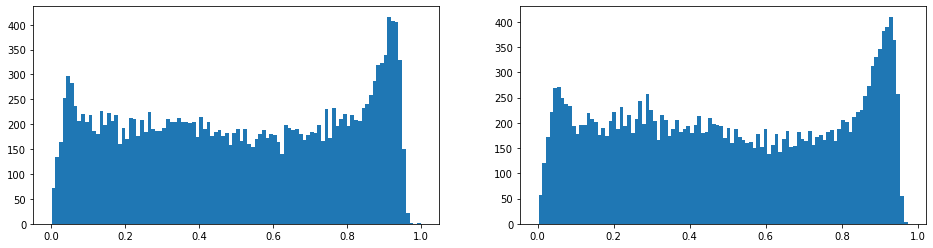

In [20]:
## LinearDiscriminantAnalysis()
print(f"score={log_loss(y['label'], val_preds)}")
fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].hist(val_preds, bins=100);
axes[1].hist(test_preds, bins=100);
plt.show()

proba_th: 0.98722


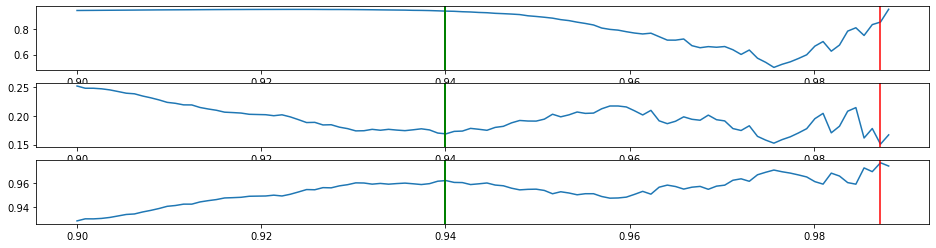

In [21]:
th_list = np.linspace(0.9, 0.989, 100, endpoint=False)
scores_roc, score_log, score_acc = [], [], []
proba_th, max_score, min_score = 0, 0, 99
for th in th_list:
    condition = ((val_preds >= th) | (val_preds <= 1-th))
    new_val_preds = val_preds[condition]
    new_val_true = y.loc[condition, 'label']
    score = roc_auc_score(new_val_true, new_val_preds)
    scores_roc.append(score)
    score = log_loss(new_val_true, new_val_preds)
    score_log.append(score)
    if score < min_score:
        min_score = score
        proba_th = th
    score = accuracy_score(new_val_true, new_val_preds.round().astype(int))
    score_acc.append(score)
print("proba_th:", proba_th)
fig, axes = plt.subplots(3, figsize=(16,4))
axes[0].plot(th_list, scores_roc);
axes[0].axvline(proba_th, color='r')
axes[0].axvline(PSEUDO_TH, color='green', linewidth=2)
axes[1].plot(th_list, score_log);
axes[1].axvline(proba_th, color='r')
axes[1].axvline(PSEUDO_TH, color='green', linewidth=2)
axes[2].plot(th_list, score_acc);
axes[2].axvline(proba_th, color='r');
axes[2].axvline(PSEUDO_TH, color='green', linewidth=2);

In [22]:
df_2d = pd.DataFrame()
df_2d["sub_0"] = train["sub_0"].values
df_2d["sub_1"] = train["sub_1"].values

df_2d["pseudo"] = 0
df_2d.loc[val_preds >= PSEUDO_TH, "pseudo"] = 1
df_2d.loc[val_preds <= 1-PSEUDO_TH, "pseudo"] = -1

df_2d["pseudo_color"] = "grey"
df_2d.loc[val_preds >= PSEUDO_TH, "pseudo_color"] = "blue"
df_2d.loc[val_preds <= 1-PSEUDO_TH, "pseudo_color"] = "blue"

df_2d["pseudo"].value_counts()

 0    18338
-1     1166
 1      496
Name: pseudo, dtype: int64

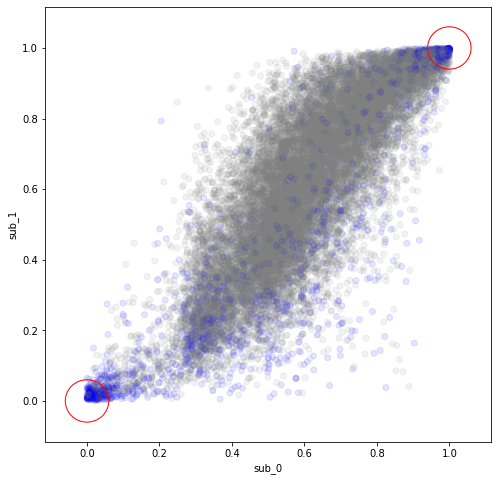

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_2d["sub_0"], df_2d["sub_1"], color=df_2d["pseudo_color"], alpha=0.1)
ax.set_ylabel("sub_1")
ax.set_xlabel("sub_0")
ax.add_patch(plt.Circle((0, 0), 1-PSEUDO_TH, color='r', fill=False, clip_on=True))
ax.add_patch(plt.Circle((1, 1), 1-PSEUDO_TH, color='r', fill=False, clip_on=True));

In [24]:
condition = ((test_preds >= PSEUDO_TH) | (test_preds <= 1-PSEUDO_TH))
train_pseudo = test.loc[condition, :]
train_pseudo['label'] = test_preds[condition].round().astype(int)
train_pseudo.reset_index(inplace=True, drop=True)
train_pseudo.to_feather("train_pseudo2.ftr")

In [25]:
print("train_pseudo.shape:", train_pseudo.shape)
train_pseudo.head()

train_pseudo.shape: (1516, 5001)


,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,...,sub_4991,sub_4992,sub_4993,sub_4994,sub_4995,sub_4996,sub_4997,sub_4998,sub_4999,label
0,0.510769,0.121118,0.161728,0.261205,0.512481,0.165255,0.310519,0.317874,0.540633,0.531018,...,0.428416,0.380975,0.545106,0.157013,0.407532,0.574039,0.565794,0.572804,0.501,0
1,0.361320,0.347783,0.055087,0.508180,0.511239,0.414870,0.386703,0.374178,0.421939,0.470217,...,0.628393,0.552348,0.603726,0.596260,0.625424,0.565772,0.307316,0.591384,0.141,0
2,0.671001,0.286648,0.246030,0.249671,0.599813,0.524274,0.349856,0.162366,0.546364,0.564960,...,0.621725,0.607564,0.716344,0.613170,0.681448,0.618902,0.456893,0.739265,0.351,0
3,0.918708,0.969526,0.994842,0.941859,0.803327,0.874479,0.934235,0.921584,0.822495,0.957115,...,0.903667,0.981070,0.970359,0.976426,0.984603,0.872210,0.980073,0.920242,0.683,1
4,0.404788,0.212052,0.622353,0.312842,0.548978,0.432661,0.572896,0.176530,0.604128,0.331153,...,0.613486,0.645798,0.512526,0.535430,0.502873,0.726607,0.698740,0.678254,0.651,0


# Baseline Modeling

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [27]:
data = pd.read_feather('../input/tps2022novfeather/train.ftr')
sub = pd.read_csv('../input/tabular-playground-series-nov-2022/sample_submission.csv')
y = pd.read_csv("../input/tabular-playground-series-nov-2022/train_labels.csv")

train = data.loc[:19999, :]
test = data.loc[20000:, :]

# Add pseudo labeled dataset
train_pseudo = pd.read_feather("../input/advanced-dataset/tpsnov22/train_pseudo2.ftr")
train["label"] = y["label"].values
train_new = pd.concat([train, train_pseudo])

print("train_new.shape:", train_new.shape)
train_new.head()

train_new.shape: (21516, 5001)


,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,...,sub_4991,sub_4992,sub_4993,sub_4994,sub_4995,sub_4996,sub_4997,sub_4998,sub_4999,label
0,0.709336,0.799007,0.851891,0.537158,0.623930,0.705970,0.503437,0.633185,0.641550,0.666604,...,0.750250,0.663370,0.739333,0.822384,0.749498,0.729800,0.867847,0.745888,0.787,0
1,0.452988,0.364453,0.567582,0.354468,0.513818,0.584119,0.454809,0.238501,0.472171,0.522314,...,0.794052,0.721298,0.804369,0.620626,0.733606,0.816942,0.814229,0.598331,0.547,1
2,0.675462,0.842260,0.800013,0.525229,0.692071,0.715418,0.651008,0.609124,0.691198,0.609994,...,0.779859,0.865657,0.828493,0.763010,0.802883,0.806891,0.896058,0.855776,0.667,1
3,0.481046,0.577118,0.683032,0.541356,0.630088,0.664514,0.413373,0.508210,0.526140,0.584565,...,0.799698,0.800130,0.716604,0.603779,0.708499,0.844837,0.853057,0.850657,0.622,1
4,0.957339,0.910337,0.917322,0.874487,0.787595,0.854273,0.843846,0.876749,0.821128,0.913054,...,0.900150,0.960911,0.906037,0.961240,0.935608,0.889757,0.978505,0.953681,0.934,0


In [28]:
train_new.drop(drop_cols, axis=1, inplace=True)
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)
print("train_new.shape:", train_new.shape)

train_new.shape: (21516, 631)


In [29]:
model_lr = LogisticRegression().fit(train.drop("label", axis=1), train["label"])
preds = model_lr.predict_proba(test)[:,1]
sub["pred"] = preds
sub.to_csv("sub_baseline.csv", index=False)

In [30]:
model_lr_p = LogisticRegression().fit(train_new.drop("label", axis=1), train_new["label"])
preds_p = model_lr_p.predict_proba(test)[:,1]
sub["pred"] = preds_p
sub.to_csv("sub_baseline_pseudo.csv", index=False)

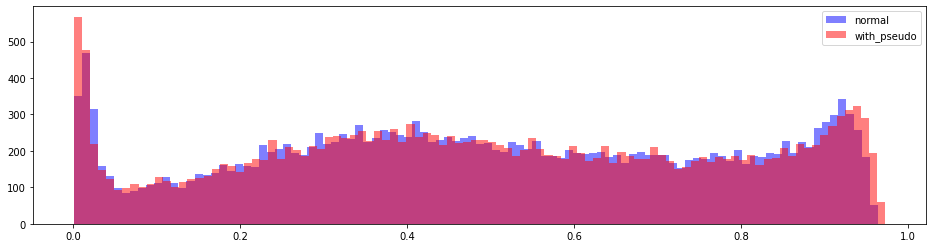

In [31]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.hist(preds, bins=100, alpha=0.5, color='b', label='normal')
ax.hist(preds_p, bins=100, alpha=0.5, color='r', label='with_pseudo')
ax.legend();

In [32]:
details = {
    "model" : ["lr_normal", "lr_pseudo"],
    "LB" : [0.53931, 0.53893]
}
df_scores = pd.DataFrame(details)
df_scores

,model,LB
0,lr_normal,0.53931
1,lr_pseudo,0.53893


# Modeling

In [33]:
def add_umap_features(X_train, y_train, X_val, X_test, nfolds=5):
    skf = StratifiedKFold(n_splits=nfolds, random_state=0, shuffle=True)
    umap_train = np.zeros((X_train.shape[0], 2))
    umap_valid = np.zeros((X_val.shape[0], 2))
    umap_test = np.zeros((X_test.shape[0], 2))
    for fold, (train_index, valid_index) in enumerate(skf.split(X_train.to_numpy(), y_train.to_numpy())):
        X_temp_train, y_temp_train = X_train.to_numpy()[train_index,:], y_train.to_numpy()[train_index,:]
        X_temp_valid, y_temp_valid = X_train.to_numpy()[valid_index,:], y_train.to_numpy()[valid_index,:]
        
        model_umap = umap.UMAP(n_neighbors=50, min_dist=0.5, metric='manhattan').fit(X_temp_train, y_temp_train)
        temp_val_preds = model_umap.transform(X_temp_valid)
        val_preds = model_umap.transform(X_val)
        test_preds = model_umap.transform(X_test)
        
        umap_train[valid_index, :] = temp_val_preds
        umap_valid[:, :] += val_preds / nfolds
        umap_test[:, :] += test_preds / nfolds
    
    return umap_train, umap_valid, umap_test

def add_pca_features(X_train, y_train, X_val, X_test, nfolds=5, n_components=4):
    skf = StratifiedKFold(n_splits=nfolds, random_state=0, shuffle=True)
    pca_train = np.zeros((X_train.shape[0], n_components))
    pca_valid = np.zeros((X_val.shape[0], n_components))
    pca_test = np.zeros((X_test.shape[0], n_components))
    for fold, (train_index, valid_index) in enumerate(skf.split(X_train.to_numpy(), y_train.to_numpy())):
        X_temp_train, y_temp_train = X_train.to_numpy()[train_index,:], y_train.to_numpy()[train_index,:]
        X_temp_valid, y_temp_valid = X_train.to_numpy()[valid_index,:], y_train.to_numpy()[valid_index,:]
        
        model_pca = PCA(n_components=n_components, random_state=42).fit(X_temp_train, y_temp_train)
        temp_val_preds = model_pca.transform(X_temp_valid)
        val_preds = model_pca.transform(X_val)
        test_preds = model_pca.transform(X_test)
        
        pca_train[valid_index, :] = temp_val_preds
        pca_valid[:, :] += val_preds / nfolds
        pca_test[:, :] += test_preds / nfolds
    
    return pca_train, pca_valid, pca_test

#umap_train, umap_valid, umap_test = add_umap_features(X, y, X_test, X_test)

In [34]:
X = train_new.drop("label", axis=1).reset_index(drop=True)
y = train_new[["label"]].reset_index(drop=True)
X_test = test

## LGBM

In [35]:
def get_lgbm_preds(X, y, X_test_ori, nfold=5, params_lgb={}):
    skf = StratifiedKFold(n_splits=nfold, random_state=0, shuffle=True)
    oof = np.zeros(X.shape[0])
    test_preds = np.zeros((X_test_ori.shape[0], nfold))
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print("\nFold {}".format(fold+1))
        X_train, y_train = X.loc[train_index,:], y.loc[train_index,:]
        X_val, y_val = X.loc[val_index,:], y.loc[val_index,:]
        X_test = X_test_ori.copy()
        
        #Adding PCA Features
        pca_train, pca_valid, pca_test = add_pca_features(X_train, y_train, X_val, X_test, nfolds=5, n_components=4)
        for feature_index in range(pca_train.shape[1]):
            X_train[f"pca_{feature_index+1}"] = pca_train[:,feature_index]
            X_val[f"pca_{feature_index+1}"] = pca_valid[:,feature_index]
            X_test[f"pca_{feature_index+1}"] = pca_test[:,feature_index]
            
        dtrain = lgb.Dataset(X_train, y_train)
        dval = lgb.Dataset(X_val, y_val)
        
        evals_result = {}
        model = lgb.train(params=params_lgb, train_set=dtrain, valid_sets=[dval], num_boost_round=3000, 
                          early_stopping_rounds=50, verbose_eval=100, evals_result=evals_result)
        
        val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        oof[val_index] = val_pred
        test_preds[:,fold] = test_pred

        del model, dtrain, dval, X_train, X_val, y_train, y_val
        gc.collect()
    test_preds = hmean(test_preds, axis=1)
    return oof, test_preds

### Hyperparameter Tuning

In [36]:
import optuna

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate": 0.01,
        "max_depth":6,
        'random_state': 42,
        "n_jobs":-1,
        "seed":123,
        "verbose":-1,
        "num_leaves":trial.suggest_int('num_leaves', 10, 200, step=10),
        "min_data_in_leaf":trial.suggest_int('min_data_in_leaf', 10, 100, step=10),
        'lambda_l1': trial.suggest_float('alpha', 0.0001, 10.0),
        'lambda_l2': trial.suggest_float('lambda', 0.0001, 10.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0, step=0.1),
    }
    
    '''
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    score_list = []
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        dtrain = lgb.Dataset(X.loc[train_index,:], y.loc[train_index,:])
        dval = lgb.Dataset(X.loc[val_index,:], y.loc[val_index,:])
        
        evals_result = {}
        model = lgb.train(params=params, train_set=dtrain, valid_sets=[dval], num_boost_round=1000, 
                          early_stopping_rounds=10, verbose_eval=0, evals_result=evals_result)
        score = evals_result['valid_0']["binary_logloss"][model.num_trees()-1]
        score_list.append(score)

        del model, dtrain, dval
        gc.collect()
    '''
    
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    trainlist, validlist = [], []
    for train_index, val_index in skf.split(X, y):
        trainlist.append(train_index)
        validlist.append(val_index)
    folds = zip(trainlist, validlist)
    
    dataset = lgb.Dataset(X, y)
    res = lgb.cv(
        params, dataset, num_boost_round=1000, verbose_eval=0,
        early_stopping_rounds=10,
        folds=folds,
        stratified=False,
    )
    
    return res["binary_logloss-mean"][-1] + res["binary_logloss-stdv"][-1]

In [37]:
'''
# Base score = 0.4804388
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=493)
print('Number of finished trials: ', len(study.trials))
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)
''';

In [38]:
params_lgb = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.003,
    "max_depth":6,
    'random_state': 42,
    "n_jobs":-1,
    "seed":123,
    "verbose":-1,
    'num_leaves': 160, 
    'min_data_in_leaf': 10, 
    'alpha': 0.5091797271529079, 
    'lambda': 0.35380392843435005, 
    'subsample': 0.9000000000000001, 
    'feature_fraction': 0.4
}

lgbm_val_preds, lgbm_test_preds = get_lgbm_preds(X, y, X_test, nfold=10, params_lgb=params_lgb)


Fold 1
[LightGBM] [Warning] seed is set=123, random_state=42 will be ignored. Current value: seed=123
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.61663
[200]	valid_0's binary_logloss: 0.571783
[300]	valid_0's binary_logloss: 0.544126
[400]	valid_0's binary_logloss: 0.526612
[500]	valid_0's binary_logloss: 0.515597
[600]	valid_0's binary_logloss: 0.508563
[700]	valid_0's binary_logloss: 0.503936
[800]	valid_0's binary_logloss: 0.500927
[900]	valid_0's binary_logloss: 0.499288
[1000]	valid_0's binary_logloss: 0.498399
[1100]	valid_0's binary_logloss: 0.497746
[1200]	valid_0's binary_logloss: 0.497186
[1300]	valid_0's binary_logloss: 0.496837
[1400]	valid_0's binary_logloss: 0.496733
[1500]	valid_0's binary_logloss: 0.496723
Early stopping, best iteration is:
[1477]	valid_0's binary_logloss: 0.496678

Fold 2
[LightGBM] [Warning] seed is set=123, random_state=42 will be ignored. Current value: seed=123
Training until validation scores don

score=0.4883603631780287


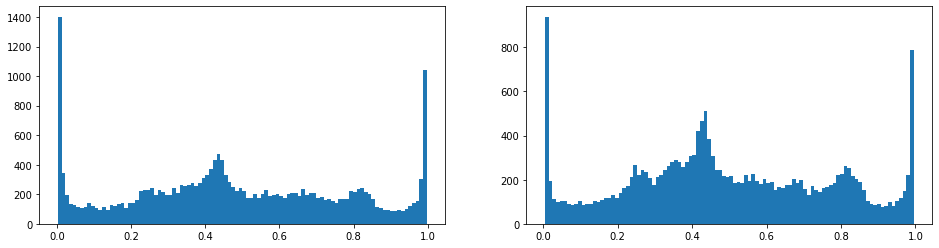

In [39]:
print(f"score={log_loss(y, lgbm_val_preds)}")
fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].hist(lgbm_val_preds, bins=100);
axes[1].hist(lgbm_test_preds, bins=100);
plt.show()

In [40]:
sub = pd.read_csv('../input/tabular-playground-series-nov-2022/sample_submission.csv')
sub["pred"] = lgbm_test_preds
sub.to_csv("sub_lgbm_pseudo.csv", index=False)

## XGB

In [41]:
def get_xgb_preds(X, y, X_test_ori, nfold=5, params_xgb={}):
    skf = StratifiedKFold(n_splits=nfold, random_state=0, shuffle=True)
    oof = np.zeros(X.shape[0])
    test_preds = np.zeros((X_test_ori.shape[0], nfold))
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print("\nFold {}".format(fold+1))
        X_train, y_train = X.loc[train_index,:], y.loc[train_index,:]
        X_val, y_val = X.loc[val_index,:], y.loc[val_index,:]
        X_test = X_test_ori.copy()
        
        #Adding PCA Features
        pca_train, pca_valid, pca_test = add_pca_features(X_train, y_train, X_val, X_test, nfolds=5, n_components=4)
        for feature_index in range(pca_train.shape[1]):
            X_train[f"pca_{feature_index+1}"] = pca_train[:,feature_index]
            X_val[f"pca_{feature_index+1}"] = pca_valid[:,feature_index]
            X_test[f"pca_{feature_index+1}"] = pca_test[:,feature_index]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        evals_result = {}
        model = xgb.train(params=params_xgb, dtrain=dtrain, evals=[(dval, "eval")], num_boost_round=3000, 
                          early_stopping_rounds=50, verbose_eval=100, evals_result=evals_result)
        
        val_pred = model.predict(dval)
        test_pred = model.predict(xgb.DMatrix(X_test))

        oof[val_index] = val_pred
        test_preds[:,fold] = test_pred

        del model, dtrain, dval, X_train, X_val, y_train, y_val
        gc.collect()
    test_preds = hmean(test_preds, axis=1)
    return oof, test_preds

In [42]:
params_xgb = {
    "objective":"binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.003,
    "max_depth":6,
    'random_state': 42,
    "n_jobs":-1,
    "seed":123,
    "tree_method":"gpu_hist",
    'alpha': 0.5091797271529079, 
    'lambda': 0.35380392843435005, 
    'subsample': 0.9, 
    'colsample_bytree': 0.4
}

xgb_val_preds, xgb_test_preds = get_xgb_preds(X, y, X_test, nfold=10, params_xgb=params_xgb)


Fold 1
[0]	eval-logloss:0.69213
[100]	eval-logloss:0.61661
[200]	eval-logloss:0.57176
[300]	eval-logloss:0.54437
[400]	eval-logloss:0.52688
[500]	eval-logloss:0.51562
[600]	eval-logloss:0.50853
[700]	eval-logloss:0.50391
[800]	eval-logloss:0.50100
[900]	eval-logloss:0.49923
[1000]	eval-logloss:0.49827
[1100]	eval-logloss:0.49771
[1200]	eval-logloss:0.49723
[1300]	eval-logloss:0.49689
[1400]	eval-logloss:0.49687
[1444]	eval-logloss:0.49685

Fold 2
[0]	eval-logloss:0.69215
[100]	eval-logloss:0.61604
[200]	eval-logloss:0.57081
[300]	eval-logloss:0.54269
[400]	eval-logloss:0.52476
[500]	eval-logloss:0.51320
[600]	eval-logloss:0.50566
[700]	eval-logloss:0.50061
[800]	eval-logloss:0.49741
[900]	eval-logloss:0.49517
[1000]	eval-logloss:0.49367
[1100]	eval-logloss:0.49266
[1200]	eval-logloss:0.49207
[1300]	eval-logloss:0.49164
[1400]	eval-logloss:0.49144
[1495]	eval-logloss:0.49140

Fold 3
[0]	eval-logloss:0.69212
[100]	eval-logloss:0.61385
[200]	eval-logloss:0.56703
[300]	eval-logloss:0.5378

score=0.4882282586472952


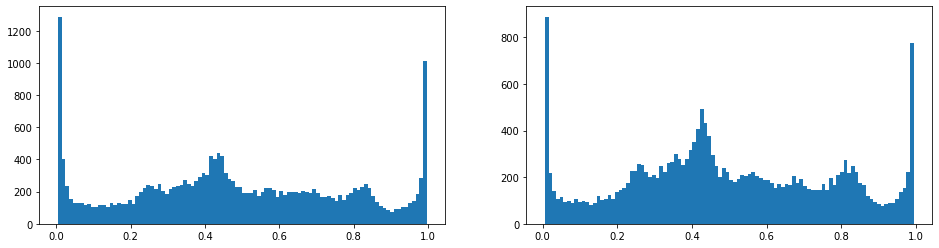

In [43]:
print(f"score={log_loss(y, xgb_val_preds)}")
fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].hist(xgb_val_preds, bins=100);
axes[1].hist(xgb_test_preds, bins=100);
plt.show()

In [44]:
sub = pd.read_csv('../input/tabular-playground-series-nov-2022/sample_submission.csv')
sub["pred"] = xgb_test_preds
sub.to_csv("sub_xgb_pseudo.csv", index=False)

# Mean Methods Comparisons

Mean Methods Comparisons [link](https://www.kaggle.com/code/hasanbasriakcay/tpsnov22-mean-methods-comparisons)

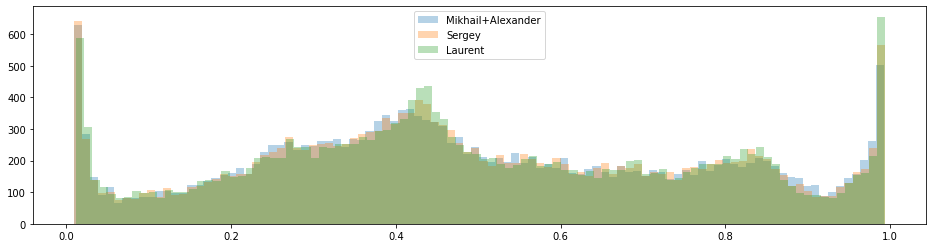

In [45]:
# notebook https://www.kaggle.com/code/mikhailkuz/lightautoml-nn-happiness/notebook?scriptVersionId=109952433
sub_mikhail_alexander = pd.read_csv("../input/lightautoml-nn-happiness/LightAutoML_submission.csv")

# https://www.kaggle.com/code/sergiosaharovskiy/tps-nov-2022-in-automl-we-trust/notebook?scriptVersionId=110041978
sub_sergey = pd.read_csv("../input/tps-nov-2022-in-automl-we-trust/LightAutoML_submission+prev_best.csv")

# https://www.kaggle.com/code/pourchot/stacking-with-scipy-minimize/notebook
sub_laurent = pd.read_csv("../input/stacking-with-scipy-minimize/submission_pred_stacked_scipy_blended2.csv")

fig, ax = plt.subplots(figsize=(16,4))
ax.hist(sub_mikhail_alexander["pred"], bins=100, alpha=0.33, label='Mikhail+Alexander')
ax.hist(sub_sergey["pred"], bins=100, alpha=0.33, label='Sergey')
ax.hist(sub_laurent["pred"], bins=100, alpha=0.33, label='Laurent')
ax.legend(loc='best');

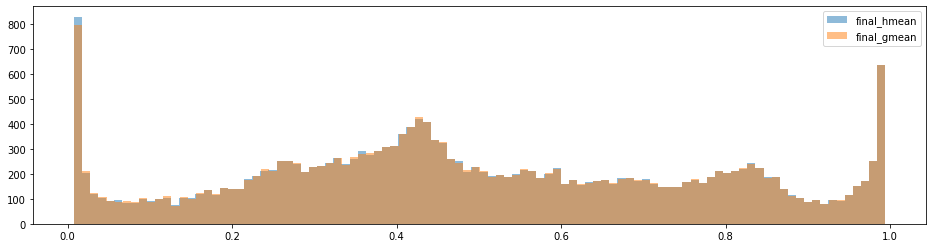

In [46]:
final_gmean_pred = gmean([xgb_test_preds, lgbm_test_preds, sub_mikhail_alexander["pred"], sub_sergey["pred"], sub_laurent["pred"]], axis=0)
sub["pred"] = final_gmean_pred
sub.to_csv("sub_final_gmean_pseudo.csv", index=False)

final_hmean_pred = hmean([xgb_test_preds, lgbm_test_preds, sub_mikhail_alexander["pred"], sub_sergey["pred"], sub_laurent["pred"]], axis=0)
sub["pred"] = final_hmean_pred
sub.to_csv("sub_final_hmean_pseudo.csv", index=False)

fig, ax = plt.subplots(figsize=(16,4))
ax.hist(final_hmean_pred, bins=100, alpha=0.5, label='final_hmean');
ax.hist(final_gmean_pred, bins=100, alpha=0.5, label='final_gmean')
ax.legend(loc='best');